### Import Important Library

In [148]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Database connection and assign table to variable


In [149]:
#Connection to database
conn = sqlite3.connect("olist.db")

#Listing all tables in database
show_tables = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

#Execute query
cursor = conn.cursor()
cursor.execute(show_tables)
print(cursor.fetchall())


[('olist_order_customer_dataset',), ('olist_order_dataset',), ('olist_order_reviews_dataset',), ('olist_order_payments_dataset',), ('olist_order_items_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('olist_geolocation_dataset',), ('product_category_name_translation',)]


In [150]:
#Assign all tables in a variable so we can easily call them
order_customer_dataset = pd.read_sql_query("SELECT * from olist_order_customer_dataset", conn)
order_dataset = pd.read_sql_query("SELECT * from olist_order_dataset", conn)
order_reviews_dataset = pd.read_sql_query("SELECT * from olist_order_reviews_dataset", conn)
order_payments_dataset = pd.read_sql_query("SELECT * from olist_order_payments_dataset", conn)
order_items_dataset = pd.read_sql_query("SELECT * from olist_order_items_dataset", conn)
products_dataset = pd.read_sql_query("SELECT * from olist_products_dataset", conn)
sellers_dataset = pd.read_sql_query("SELECT * from olist_sellers_dataset", conn)
geolocation_dataset = pd.read_sql_query("SELECT * from olist_geolocation_dataset", conn)
product_category_name_translation = pd.read_sql_query("SELECT * from product_category_name_translation", conn)


## Preprocessing Columns

### Merge intersecting columns

In [151]:
order_items_products = pd.merge(order_items_dataset,products_dataset,on='product_id')
order_items_products_sellers = pd.merge(order_items_products,sellers_dataset,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,order_dataset,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,order_customer_dataset,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,order_reviews_dataset,on='order_id')

#We can finalize dataframe after merging several columns
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,order_payments_dataset,on='order_id')

/tmp/ipykernel_475/4031734409.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  two_order_items_products_sellers = pd.merge(order_items_products_sellers,order_dataset,on='order_id')
/tmp/ipykernel_475/4031734409.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,order_reviews_dataset,on='order_id')


### Replace columns

In [152]:
#Replace "product category name" (Portuguese) table with "product category name translation" (English)
mapping = dict(zip(product_category_name_translation['product_category_name'].tolist(),product_category_name_translation['product_category_name_english'].tolist()))
final_dataframe['product_category_name'] = final_dataframe['product_category_name'].map(mapping)

In [153]:
#Final dataset for explore
final_dataframe.head(3)

,index_x,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_y,product_category_name,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,payment_sequential,payment_type,payment_installments,payment_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,25865,cool_stuff,...,5,None,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,85283,1,credit_card,2,72.19
1,8346,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,25865,cool_stuff,...,5,None,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,39274,1,boleto,1,73.86
2,36646,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,25865,cool_stuff,...,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,87067,1,credit_card,2,83.23


### Drop index columns

In [154]:
#Drop index columns, cause we don't need them
final_dataframe = final_dataframe.drop(columns=['index_x', 'index_y', 'index'])

In [155]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(117329, 39)

### Drop duplicates

In [156]:
#Dropping all the duplicates which have the same Order ID, Customer ID, purchase timestamp, review message.
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(101878, 39)

In [157]:
#After dropall duplicates, finally all the ID values are unique. We are dropping these columns since they don't contribute much to understanding the data.
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [158]:
#Drop rows which contain null value
final_dataframe = final_dataframe.dropna(subset=['shipping_limit_date','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp'])

In [159]:
'''Parsing datetime and extracting information
purchase delivery difference = differences time of purchase and delivery 
estimated actual delivery difference = delay or cut down in number of days actually required fro delivery
'''

intermediate_time = final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_purchase_timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['purchase-delivery difference'] = intermediate_time.apply(lambda x:x.days)

intermediate_time = final_dataframe['order_estimated_delivery_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['estimated-actual delivery difference'] = intermediate_time.apply(lambda x:x.days)

In [160]:
#Checking null value
final_dataframe.isnull().sum()

order_item_id                               0
shipping_limit_date                         0
price                                       0
freight_value                               0
product_category_name                    1416
product_name_lenght                      1396
product_description_lenght               1396
product_photos_qty                       1396
product_weight_g                           16
product_length_cm                          16
product_height_cm                          16
product_width_cm                           16
seller_zip_code_prefix                      0
seller_city                                 0
seller_state                                0
customer_id                                 0
order_status                                0
order_purchase_timestamp                    0
order_approved_at                          14
order_delivered_carrier_date                0
order_delivered_customer_date               0
order_estimated_delivery_date     

### All null value that found shall we impute.

- categorical columns -> use mode
- numerical columns -> use median

In [161]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_title'].fillna(value='indisponível', inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

In [162]:
final_dataframe['review_score'].describe()

count    99741.000000
mean         4.124823
std          1.311385
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

In [163]:
#Classify review to 1 and 0 value. If review more than 3 classify to 1, else 0.

final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

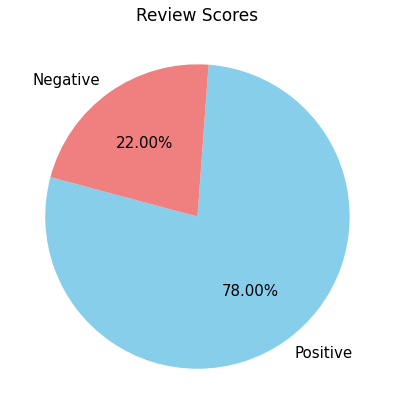

In [164]:
#plotting sentimen review into pie chart
plt.figure(figsize=(7,7))
colors = ['skyblue', 'lightcoral', 'white']
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=colors)
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

In [165]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']].describe()

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,99741.000000,99741.000000,99741.000000,99741.000000,99741.000000,99741.000000,99741.000000,99741.000000
mean,123.530085,20.061342,49.051092,783.596585,2082.758886,30.061920,16.357436,23.024313
std,186.163938,15.762504,9.976598,645.220610,3736.407037,16.054294,13.264415,11.723665
min,0.850000,0.000000,5.000000,4.000000,0.000000,7.000000,2.000000,6.000000
25%,40.000000,13.140000,43.000000,348.000000,300.000000,18.000000,8.000000,15.000000
50%,78.000000,16.320000,52.000000,602.000000,683.000000,25.000000,13.000000,20.000000
75%,139.000000,21.180000,57.000000,980.000000,1800.000000,38.000000,20.000000,30.000000
max,6735.000000,409.680000,76.000000,3992.000000,40425.000000,105.000000,105.000000,118.000000


In [166]:
#Create price category. This column is used to categorize the goods as expensive, cheap and affordable based on their price.

final_dataframe['price_category'] = final_dataframe['price'].apply(lambda x:'expensive' if x>=139 else ('affordable' if x>=40 and x<139 else 'cheap'))

# The Analysis

## Top 10 popular product

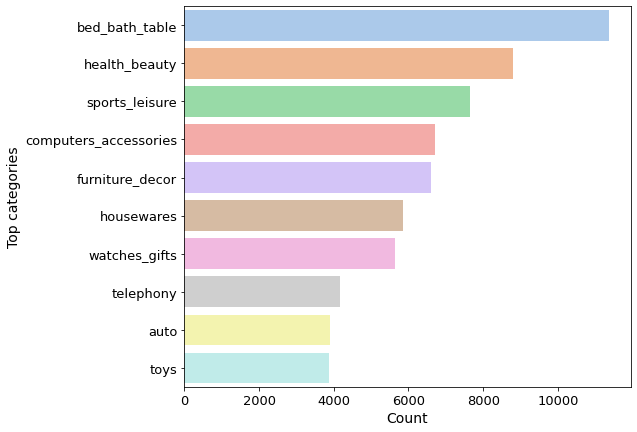

In [167]:
'''We are now finding the top 10 most popular product categories in terms of the frequency of purchase.
The category 'bed bath table' significantly more popular than most of the other categories.
It is the only category whose sales have crossed 10000 units.
The category in the 10th position - 'toys' only had around 3700 units sold.'''
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:10].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="pastel")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

## Top 10 state with highest customer

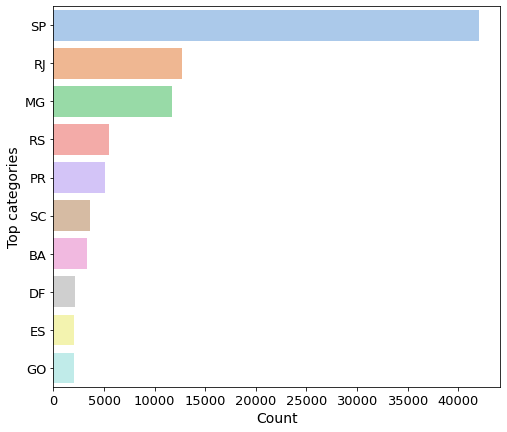

In [168]:
#SP -> Sao Paulo,  the state with the highest customer base
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:10].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="pastel")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

## Top 10 most expensive product (average)

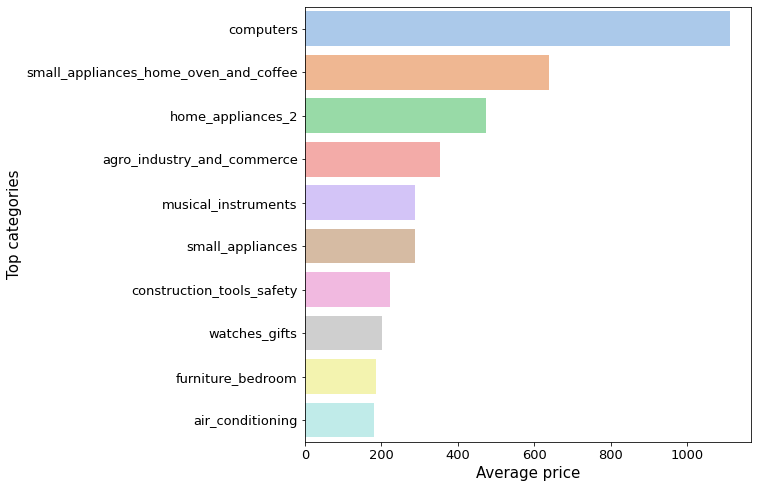

In [169]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:10])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="pastel")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

## Top 10 products with the most shipping costs

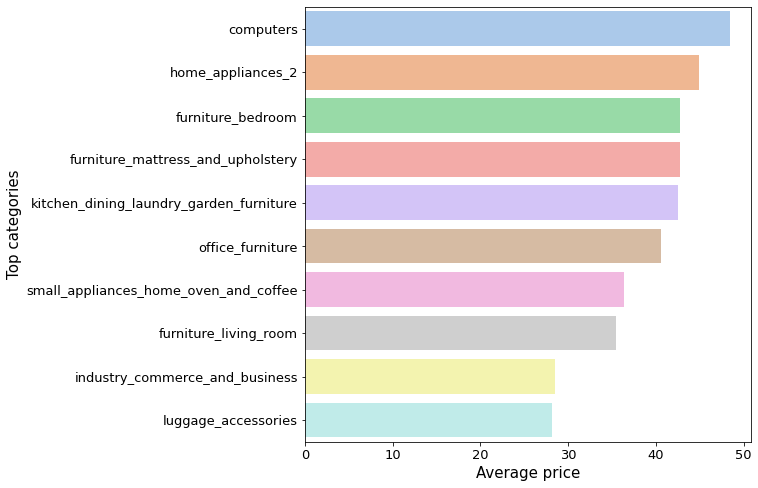

In [179]:
#Shipping cost (average)
grp_dict = dict((grp_cat_name.mean()['freight_value']).sort_values(ascending=False)[:10])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="pastel")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

## Top 10 cities generate the most revenue

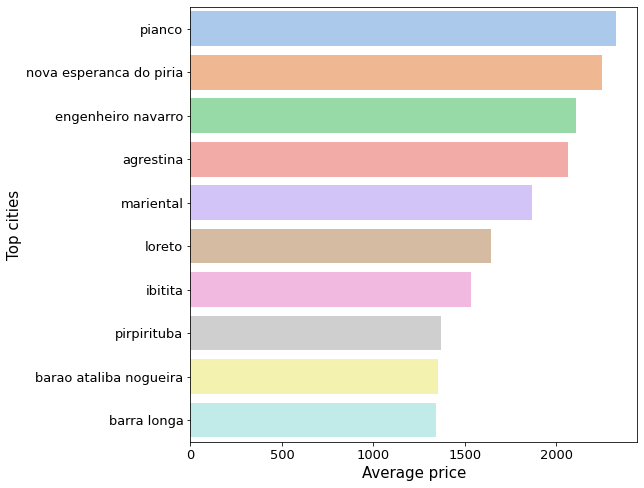

In [171]:
grp_state_name = final_dataframe.groupby('customer_city')
grp_dict = dict((grp_state_name.mean()['price']+grp_state_name.mean()['freight_value']).sort_values(ascending=False)[:10])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="pastel")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top cities', fontsize=15)
plt.show()

In [172]:
final_dataframe['order_status'].value_counts()

delivered    99734
canceled         7
Name: order_status, dtype: int64

In [173]:
#Drop canceled status order row
final_dataframe = final_dataframe[final_dataframe['order_status'] != 'canceled']

In [174]:
final_dataframe.head()

,order_item_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,...,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,purchase-delivery difference,estimated-actual delivery difference,price_category
0,1,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,...,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19,7,9,affordable
1,1,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,...,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86,15,13,affordable
2,1,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,...,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23,17,3,affordable
3,1,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,...,indisponível,2017-08-10 00:00:00,2017-08-13 03:35:17,1,credit_card,3,75.07,8,16,affordable
4,1,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,...,indisponível,2017-08-25 00:00:00,2017-08-28 00:51:18,1,credit_card,4,72.19,14,8,affordable


## Distribution of review score on delivery time and price

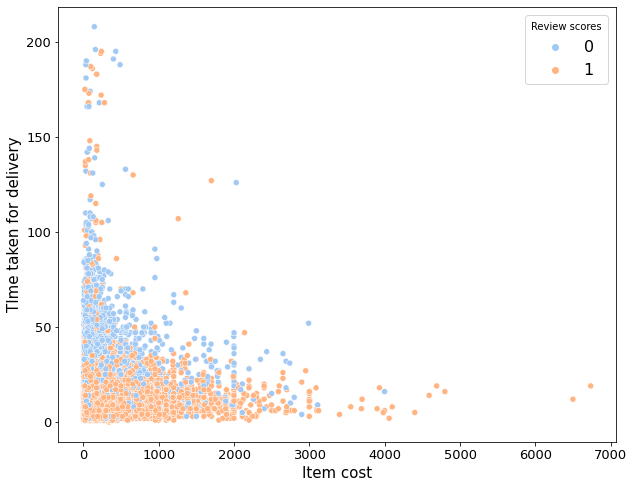

In [175]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['purchase-delivery difference'],hue=final_dataframe['review_score'],palette="pastel")
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('TIme taken for delivery', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [176]:
final_dataframe['purchase_delivery_diff_per_price'] = final_dataframe['purchase-delivery difference']/final_dataframe['price']

/tmp/ipykernel_475/3966002548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe['purchase_delivery_diff_per_price'] = final_dataframe['purchase-delivery difference']/final_dataframe['price']


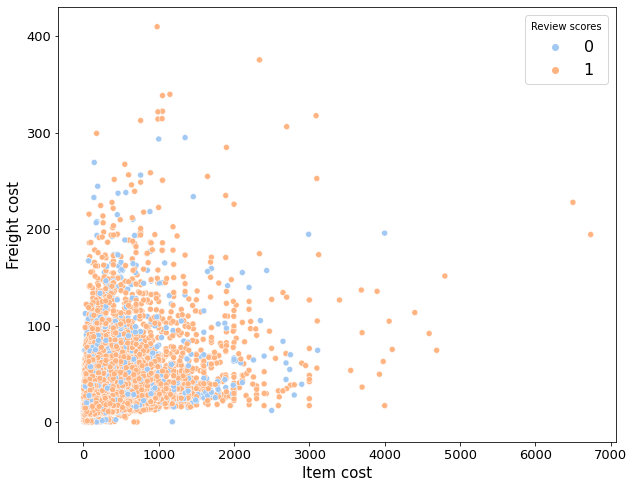

In [177]:
#Even if the freight cost is high, customers were satisfied when the item cost is less.
plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['freight_value'],hue=final_dataframe['review_score'], palette='pastel')
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('Freight cost', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Most popular payment type

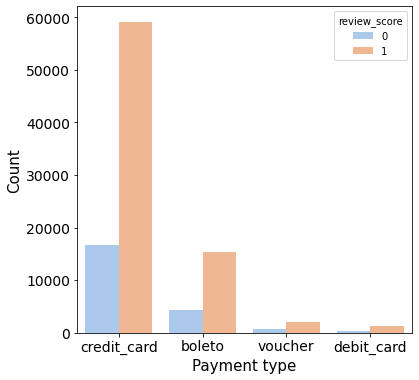

In [178]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='pastel')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()